<a href="https://colab.research.google.com/github/apof/ChAI---Deep-Kernel-Learning-combining-GPs-with-DL/blob/main/Deep_Kernel_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gpytorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import joblib
from IPython.display import clear_output
import matplotlib.pyplot as plt
from torch.autograd import Variable
import copy
import plotly.graph_objs as go


import math
import tqdm
import torch
import gpytorch
from matplotlib import pyplot as plt

# Make plots inline
%matplotlib inline

In [ ]:
NN = 'MLP'
#NN = 'RNN'
#NN = None

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## immport useful utilities from previous coursework
import sys
sys.path.insert(0,'drive/MyDrive/SNLP/')
import utils
import models

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
if(NN == 'RNN'):
  aluminium_inputs = joblib.load('drive/MyDrive/Thesis_Vectors/small_h_aluminium_vectors')
  aluminium_labels = joblib.load('drive/MyDrive/Thesis_Vectors/small_h_aluminium_labels')
  aluminium_dates = joblib.load('drive/MyDrive/Thesis_Vectors/small_h_aluminium_dates')

  '''aluminium_inputs = joblib.load('drive/MyDrive/Thesis_Vectors/small_f_aluminium_vectors')
  aluminium_labels = joblib.load('drive/MyDrive/Thesis_Vectors/small_f_aluminium_labels')
  aluminium_dates = joblib.load('drive/MyDrive/Thesis_Vectors/small_f_aluminium_dates')'''


  aluminium_inputs = aluminium_inputs[0:1500]
  aluminium_labels = aluminium_labels[0:1500]
  aluminium_dates = aluminium_dates[0:1500]


else:

  aluminium_inputs = joblib.load('drive/MyDrive/Thesis_Vectors/single_h_aluminium_vectors')
  aluminium_labels = joblib.load('drive/MyDrive/Thesis_Vectors/single_h_aluminium_labels')
  aluminium_dates = joblib.load('drive/MyDrive/Thesis_Vectors/single_h_aluminium_dates')

  '''aluminium_inputs = joblib.load('drive/MyDrive/Thesis_Vectors/single_f_aluminium_vectors')
  aluminium_labels = joblib.load('drive/MyDrive/Thesis_Vectors/single_f_aluminium_labels')
  aluminium_dates = joblib.load('drive/MyDrive/Thesis_Vectors/single_f_aluminium_dates')'''

  aluminium_inputs = aluminium_inputs[0:2500]
  aluminium_labels = aluminium_labels[0:2500]
  aluminium_dates = aluminium_dates[0:2500]

In [ ]:
train_batches,validation_batches,test_batches = utils.train_test_split(aluminium_inputs,aluminium_labels,aluminium_dates,aluminium_inputs.shape[0],0.8,0.7,0)

In [ ]:
train_data,train_labels,train_dates = train_batches[0]
test_data,test_labels,test_dates = test_batches[0]
val_data,val_labels,val_dates = validation_batches[0]

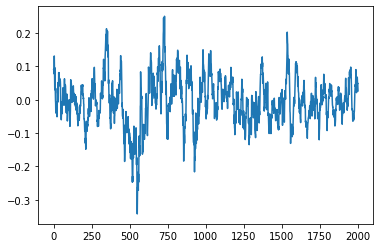

In [ ]:
index = [i+1 for i in range(len(train_labels))]
plt.plot(index, train_labels)

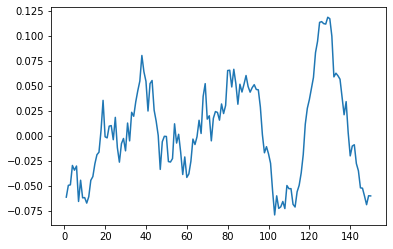

In [ ]:
index = [i+1 for i in range(len(test_labels))]
plt.plot(index, test_labels)

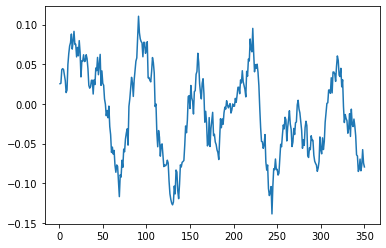

In [ ]:
index = [i+1 for i in range(len(val_labels))]
plt.plot(index, val_labels)

In [ ]:
train_data = torch.from_numpy(train_data).to(device)
train_labels = torch.from_numpy(train_labels).to(device)
test_data = torch.from_numpy(test_data).to(device)
test_labels = torch.from_numpy(test_labels).to(device)
val_data = torch.from_numpy(val_data).to(device)
val_labels = torch.from_numpy(val_labels).to(device)
train_data = torch.squeeze(train_data, dim = 1)
test_data = torch.squeeze(test_data, dim = 1)
val_data = torch.squeeze(val_data, dim = 1)

In [ ]:
if(NN == 'RNN'):
  timesteps = train_data.shape[1]
  features_num = train_data.shape[2]
  print(timesteps)
  print(features_num)
  train_data = torch.reshape(train_data, (-1,timesteps*features_num))
  val_data = torch.reshape(val_data, (-1,timesteps*features_num))
  test_data = torch.reshape(test_data, (-1,timesteps*features_num))

In [ ]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)
print(val_data.shape)
print(val_labels.shape)

torch.Size([2000, 28])
torch.Size([2000])
torch.Size([150, 28])
torch.Size([150])
torch.Size([350, 28])
torch.Size([350])


In [ ]:
if(NN!=None):
  representation_dim = 10
else:
  representation_dim = train_data.shape[1]
KERNEL = 'RBF'
#KERNEL = 'MIX'
#KERNEL = 'MATERN'

In [ ]:
## define a dictionary with the parameters of the Neural Network
params_dictionary = {}
if(NN == 'RNN'):
  params_dictionary['embedding_size'] = (features_num,features_num)
else:
  params_dictionary['embedding_size'] = (train_data[0].shape[0],train_data[0].shape[0])
params_dictionary['hidden_dim'] = 512
params_dictionary['linear_dims'] = [256,128,representation_dim]
params_dictionary['bidirectional'] = False
params_dictionary['label_size'] = 2
params_dictionary['dropout'] = 0.3
params_dictionary['rnn_layers_num'] = 1
params_dictionary['concat_layer'] = [32]
params_dictionary['timesteps'] = train_data[0].shape[0]
params_dictionary['attention_layer'] = True
params_dictionary['kernel_size'] = 5
params_dictionary['cnn_reduced_dim_1'] = 25
params_dictionary['cnn_reduced_dim_2'] = 14
params_dictionary['cnn_layer'] = False

In [ ]:
if(NN == 'MLP'):    
  feature_extractor = models.MLPFeatureExtractor(train_data.size(-1),representation_dim).to(device)
else:
  feature_extractor = models.RnnRegressor(device,params_dictionary,0)

In [ ]:
class GPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood, params_dictionary):
            super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)

            self.mean_module = gpytorch.means.ConstantMean()
            self.param_dict = params_dictionary

            if(KERNEL == 'RBF'):
                self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
            elif(KERNEL == 'MIX'):
                self.covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=4, ard_num_dims=representation_dim)
            else:
                self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=0.5))

            self.hidden = None

        def set_feature_extractor(self,nn):  
            self.feature_extractor = nn
           
        def forward(self, x):
            #print('forward shape:  ' + str(x.shape))
            # We're first putting our data through a deep net (feature extractor)
            # We're also scaling the features so that they're nice values
            if(NN == 'RNN'):
              x = torch.reshape(x, (-1,timesteps,features_num))
              projected_x,self.hidden = self.feature_extractor((x.to(dtype=torch.float16),True,None),self.param_dict)
            elif(NN == 'MLP'):
              projected_x = self.feature_extractor(x.float())
            else:
              projected_x = x
              
            #print(projected_x.shape)
            #print(projected_x.dtype)
            
            #projected_x = projected_x - projected_x.min(0)[0]
            #projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        
        
        def get_representation(self,x):
          if(NN == 'RNN'):
            x = torch.reshape(x, (-1,timesteps,features_num))
            return self.feature_extractor((x,True,self.hidden),params_dictionary)[0]
          else:
            return self.feature_extractor(x)

In [ ]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_data,train_labels, likelihood, params_dictionary).double()
model.set_feature_extractor(feature_extractor)

model = model.to(device)
likelihood = likelihood.to(device)

In [ ]:
print(model)

GPRegressionModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
  (feature_extractor): MLPFeatureExtractor(
    (linear1): Linear(in_features=28, out_features=128, bias=True)
    (relu1): ReLU()
    (linear2): Linear(in_features=128, out_features=64, bias=True)
    (relu3): ReLU()
    (linear4): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [ ]:

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.feature_extractor.parameters()},
    {'params': model.covar_module.parameters()},
    {'params': model.mean_module.parameters()},
    {'params': model.likelihood.parameters()},
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 5000

training_loss = []
validation_loss = []

def train():
    
    best_cost=1000000 
    stop = False
    last_improvement=0
    require_improvement = 200
    best_model = None
    epoch = 0
    
    while(stop == False):
        # Find optimal model hyperparameters
        model.train()
        likelihood.train()
        
        epoch += 1
        
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_data)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_labels)
        training_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
        print("epoch  " + str(epoch+1) + " " + str(training_loss[-1]))
        clear_output(wait=True)
        
        # Get into evaluation (predictive posterior) mode
        model.eval()
        likelihood.eval()
                
        with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.use_toeplitz(False):

            #print(val_data.shape)
            #print(val_labels.shape)
            ## Calculate the validation loss
            val_loss = -mll(model(val_data), val_labels)
            validation_loss.append(val_loss.item())
            
            
            avg_cost = val_loss
            if avg_cost < best_cost:
                best_cost = avg_cost
                last_improvement = 0
                best_model_state = copy.deepcopy(model.state_dict())
                torch.save(best_model_state, 'DKL.pt')
            else:
                last_improvement +=1
                
            if last_improvement > require_improvement:
                print("No improvement found during the last iterations, stopping optimization at epoch: " + str(epoch))
                # Break out from the loop.
                stop = True
        

%time train()

No improvement found during the last iterations, stopping optimization at epoch: 731
CPU times: user 45.7 s, sys: 751 ms, total: 46.5 s
Wall time: 44.4 s


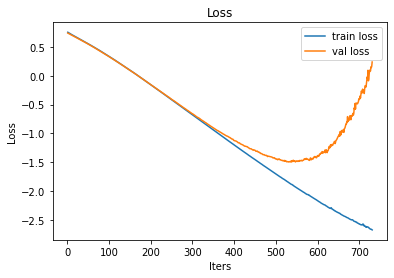

In [ ]:
index = [i+1 for i in range(len(training_loss))]
plt.plot(index, training_loss, label = "train loss")
plt.plot(index, validation_loss, label = "val loss")
plt.xlabel('Iters')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
model.eval()
likelihood.eval()
predictions = []

data= torch.cat((val_data, test_data), 0)
labels = torch.cat((val_labels, test_labels), 0)
#data = val_data
#labels = val_labels


with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions.append(likelihood(model(data)))


In [ ]:
pred_means = []
pred_uconf = []
pred_lconf = []

for p in predictions:
    pred_means.append(p.mean.cpu().numpy())
    l, u = p.confidence_region()
    pred_lconf.append(l.cpu().detach().numpy())
    pred_uconf.append(u.cpu().detach().numpy())
pred_means = pred_means[0]
pred_uconf  = pred_uconf[0]
pred_lconf = pred_lconf[0]

In [ ]:
def find_bound_coverage(pred,u_bound,l_bound):
    inside = 0
    outside = 0
    for i,p in enumerate(pred):
        if(p < u_bound[i] and p > l_bound[i]):
            inside += 1
        else:
            outside += 1
    return (inside * 100)/len(pred), (outside * 100)/len(pred)

In [ ]:
inside_percenatge, outside_percentage = find_bound_coverage(labels,pred_uconf,pred_lconf)

In [ ]:
print('Inside Percenatge: ' + str(inside_percenatge))
print('Outside Percenatge: ' + str(outside_percentage))

Inside Percenatge: 56.6
Outside Percenatge: 43.4


In [ ]:
index = [i+1 for i in range(pred_means.shape[0])]

In [ ]:
print(len(labels))
print(len(pred_means))

500
500


In [ ]:
pred_means

array([ 0.04769971,  0.05465623,  0.05794794,  0.05471527,  0.05437496,
        0.05105293,  0.06630863,  0.0589017 ,  0.03081705,  0.02832932,
        0.03494496,  0.02865238,  0.02675072,  0.0219918 ,  0.00398961,
       -0.01475588, -0.03034212, -0.0209169 , -0.03034212, -0.03034212,
       -0.03034212, -0.04492057, -0.03034212, -0.05110026, -0.04547092,
       -0.03071373, -0.03034212, -0.03034212, -0.0332028 , -0.04407238,
       -0.06082977, -0.06088378, -0.05669835, -0.00871147, -0.00894957,
       -0.01282761, -0.02663626, -0.02900685, -0.0004564 ,  0.00873593,
        0.01891635,  0.01929062,  0.02179836,  0.00996495,  0.01096855,
        0.00512249, -0.00202843,  0.00798437,  0.0105206 ,  0.010832  ,
        0.00904968,  0.00970798,  0.00558588, -0.00728347, -0.01533205,
       -0.01316089, -0.01204919, -0.01329237, -0.03418879, -0.03510451,
       -0.02451465, -0.02423264, -0.02898436, -0.00302379,  0.01863678,
        0.02141818,  0.02108006,  0.0280684 ,  0.03789888,  0.03

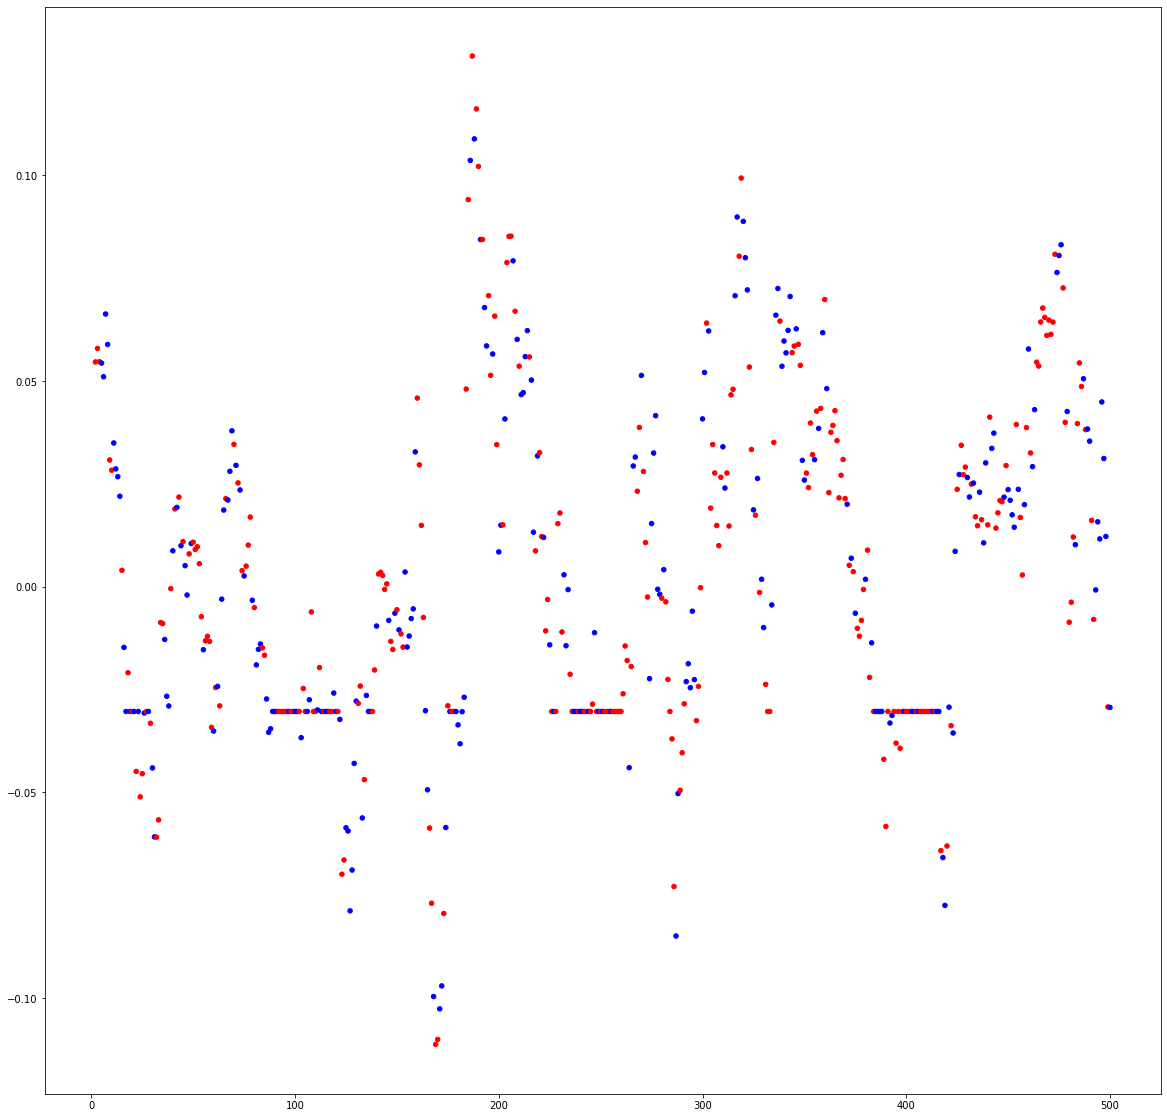

In [ ]:
utils.plot_directional_results(pred_means,labels.cpu().detach().numpy(),index)

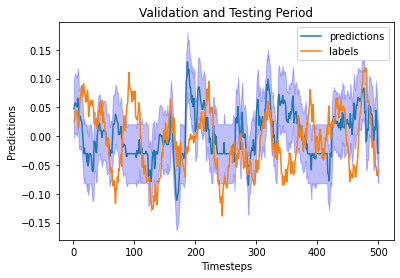

In [ ]:
fig, ax = plt.subplots()
ax.plot(index,pred_means,label = 'predictions')
ax.plot(index,labels.cpu().detach().numpy(),label = 'labels')
ax.fill_between(index, pred_lconf, pred_uconf, color='b', alpha=.25)
plt.xlabel('Timesteps')
plt.ylabel('Predictions')
plt.title('Validation and Testing Period')
plt.legend()
plt.show()

In [ ]:
low_dim_represenations = model.get_representation(train_data.float()).cpu().detach().numpy()

In [ ]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.decomposition import PCA

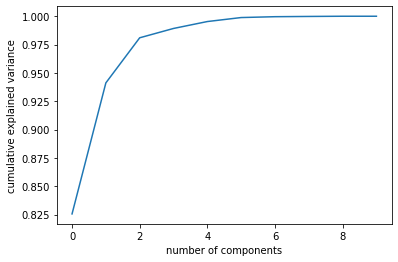

In [ ]:
pca = PCA().fit(low_dim_represenations)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [ ]:
pca_3d = PCA(n_components=3)
pca_2d = PCA(n_components=2)
pca_3d.fit(low_dim_represenations)
pca_2d.fit(low_dim_represenations)

low_dim_represenations_2d = pca_2d.transform(low_dim_represenations)
low_dim_represenations_3d = pca_3d.transform(low_dim_represenations)

In [ ]:
x = low_dim_represenations_3d[:,0]
y = low_dim_represenations_3d[:,1]
z = low_dim_represenations_3d[:,2]

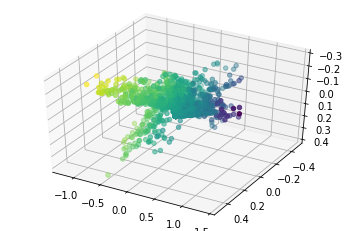

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x, y, z, c=train_labels.cpu().detach().numpy())
ax.view_init(-140, 600)
plt.savefig('drive/MyDrive/Visualisations/3d-DKL-repre.png')


In [ ]:
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        color=train_labels.cpu().detach().numpy(),                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

In [ ]:
x = low_dim_represenations_2d[:,0]
y = low_dim_represenations_2d[:,1]

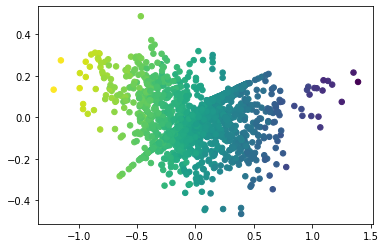

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.scatter(x, y, c=train_labels.cpu().detach().numpy(), s=30)
plt.show()
plt.savefig('drive/MyDrive/Visualisations/2d-DKL-repre.png')

In [ ]:
print("Mean Directional Accuracy: " + str(utils.mean_directional_accuracy(labels.cpu().detach().numpy(),pred_means)))
print("Root Mean Squared Error : " + str(utils.rmse(pred_means, labels.cpu().detach().numpy())))

Mean Directional Accuracy: 0.5410821643286573
Root Mean Squared Error : 0.062469715468560096
